# Hotel neighborhood selection advisor

Import all the necessary libraries

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.18.1-py_0 conda-forge

geographiclib- 100% |################################| Time: 0:00:00  23.82 MB/s
geopy-1.18.1-p 100% |################################| Time: 0:00:00  33.76 MB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  39.04 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  26.31 MB/s
vincent-0.4.4- 100% |###################

## Creating user hotels dataset. 
Look at some hotel (coordinates and map)

In [198]:
address = 'BonHotel, Minsk'

geolocator = Nominatim(user_agent="hotel_app")
location = geolocator.geocode(address)
latitude_bonHotel = location.latitude
longitude_bonHotel = location.longitude
print('The geograpical coordinate of Bonhotel are {}, {}.'.format(latitude_bonHotel, longitude_bonHotel))
map_bonHotel = folium.Map(location=[latitude_bonHotel, longitude_bonHotel], zoom_start=16)
map_bonHotel


The geograpical coordinate of Bonhotel are 53.91053475, 27.5060563818736.


In [199]:
address = 'Ibis Wien Mariahilf'

geolocator = Nominatim(user_agent="hotel_app")
location = geolocator.geocode(address)
latitude_Ibis = location.latitude
longitude_Ibis = location.longitude
print('The geograpical coordinate of Ibis Wien Mariahilf are {}, {}.'.format(latitude_Ibis, longitude_Ibis))
map_Ibis = folium.Map(location=[latitude_Ibis, longitude_Ibis], zoom_start=16)
map_Ibis

The geograpical coordinate of Ibis Wien Mariahilf are 48.19321425, 16.3394613395099.


In [200]:
address = 'Hotel Steglitz International'

geolocator = Nominatim(user_agent="hotel_app")
location = geolocator.geocode(address)
latitude_Steglitz = location.latitude
longitude_Steglitz = location.longitude
print('The geograpical coordinate of Hotel Steglitz International are {}, {}.'.format(latitude_Steglitz, longitude_Steglitz))
map_Steglitz = folium.Map(location=[latitude_Steglitz, longitude_Steglitz], zoom_start=16)
map_Steglitz

The geograpical coordinate of Hotel Steglitz International are 52.4562628, 13.3212357.


In [201]:
address = 'Radisson Blue, Ukraine'
geolocator = Nominatim(user_agent="hotel_app")
location = geolocator.geocode(address)
latitude_Radisson = location.latitude
longitude_Radisson = location.longitude
print('The geograpical coordinate of Radisson Blue, Ukraine are {}, {}.'.format(latitude_Radisson, longitude_Radisson))
map_Radisson = folium.Map(location=[latitude_Radisson, longitude_Radisson], zoom_start=16)
map_Radisson

The geograpical coordinate of Radisson Blue, Ukraine are 50.4515838, 30.5096548944131.


### Create dataset from hotels coordinates

In [202]:
hotels = [{'hotel_Name': 'BonHotel, Minsk', 'latitude': latitude_bonHotel, 'longitude': longitude_bonHotel},
         {'hotel_Name': 'Ibis Wien Mariahilf',  'latitude': latitude_Ibis, 'longitude': longitude_Ibis},
         {'hotel_Name': 'Hotel Steglitz International',  'latitude': latitude_Steglitz,  'longitude': longitude_Steglitz},
         {'hotel_Name': 'Radisson Blue, Ukraine',  'latitude': latitude_Radisson,  'longitude': longitude_Radisson}
         ]
hotelsDF = pd.DataFrame(hotels)
hotelsDF

,hotel_Name,latitude,longitude
0,"BonHotel, Minsk",53.910535,27.506056
1,Ibis Wien Mariahilf,48.193214,16.339461
2,Hotel Steglitz International,52.456263,13.321236
3,"Radisson Blue, Ukraine",50.451584,30.509655


In [203]:
CLIENT_ID = 'WC2PZSU1NPSRGYFZ2HGCDJYGTEJD33Q1HDE0WBOODCEOHX1B' # your Foursquare ID
CLIENT_SECRET = 'QBQ5IT43MMZUZZEMBCKB5P1QGCHXSF15DSJD1HLW2KWFG0AB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WC2PZSU1NPSRGYFZ2HGCDJYGTEJD33Q1HDE0WBOODCEOHX1B
CLIENT_SECRET:QBQ5IT43MMZUZZEMBCKB5P1QGCHXSF15DSJD1HLW2KWFG0AB


In [204]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [205]:
hotels_venues = getNearbyVenues(names=hotelsDF['hotel_Name'],
                                   latitudes=hotelsDF['latitude'],
                                   longitudes=hotelsDF['longitude']
                                  )

BonHotel, Minsk
Ibis Wien Mariahilf
Hotel Steglitz International
Radisson Blue, Ukraine


In [206]:
hotels_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"BonHotel, Minsk",26,26,26,26,26,26
Hotel Steglitz International,29,29,29,29,29,29
Ibis Wien Mariahilf,82,82,82,82,82,82
"Radisson Blue, Ukraine",80,80,80,80,80,80


In [207]:
print('There are {} uniques categories.'.format(len(hotels_venues['Venue Category'].unique())))

There are 103 uniques categories.


In [208]:
# one hot encoding
hotels_onehot = pd.get_dummies(hotels_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hotels_onehot['Neighborhood'] = hotels_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [hotels_onehot.columns[-1]] + list(hotels_onehot.columns[:-1])
hotels_onehot = hotels_onehot[fixed_columns]

hotels_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Bakery,Bar,Bistro,Bookstore,Breakfast Spot,Brewery,Bridal Shop,Burger Joint,Bus Line,Bus Stop,Café,Camera Store,Caucasian Restaurant,Cemetery,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Cuban Restaurant,Currywurst Joint,Dance Studio,Dessert Shop,Dim Sum Restaurant,Doner Restaurant,Eastern European Restaurant,Electronics Store,Flower Shop,Food & Drink Shop,Fountain,French Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Health & Beauty Service,Historic Site,Hobby Shop,Hookah Bar,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lounge,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Middle Eastern Restaurant,Museum,Newsstand,Optical Shop,Outdoor Sculpture,Outdoor Supply Store,Park,Pharmacy,Pizza Place,Plaza,Pool Hall,Pub,Racetrack,Restaurant,Road,Romanian Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Repair,Shopping Mall,Snack Place,Soup Place,Sporting Goods Shop,Supermarket,Sushi Restaurant,Tailor Shop,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Train Station,Tram Station,Trattoria/Osteria,Vape Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Watch Shop,Wine Bar,Women's Store,Zoo Exhibit
0,"BonHotel, Minsk",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"BonHotel, Minsk",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"BonHotel, Minsk",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"BonHotel, Minsk",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"BonHotel, Minsk",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [209]:
hotels_grouped = hotels_onehot.groupby('Neighborhood').mean().reset_index()
hotels_grouped

,Neighborhood,Accessories Store,American Restaurant,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Bakery,Bar,Bistro,Bookstore,Breakfast Spot,Brewery,Bridal Shop,Burger Joint,Bus Line,Bus Stop,Café,Camera Store,Caucasian Restaurant,Cemetery,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Cuban Restaurant,Currywurst Joint,Dance Studio,Dessert Shop,Dim Sum Restaurant,Doner Restaurant,Eastern European Restaurant,Electronics Store,Flower Shop,Food & Drink Shop,Fountain,French Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Health & Beauty Service,Historic Site,Hobby Shop,Hookah Bar,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lounge,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Middle Eastern Restaurant,Museum,Newsstand,Optical Shop,Outdoor Sculpture,Outdoor Supply Store,Park,Pharmacy,Pizza Place,Plaza,Pool Hall,Pub,Racetrack,Restaurant,Road,Romanian Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Repair,Shopping Mall,Snack Place,Soup Place,Sporting Goods Shop,Supermarket,Sushi Restaurant,Tailor Shop,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Train Station,Tram Station,Trattoria/Osteria,Vape Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Watch Shop,Wine Bar,Women's Store,Zoo Exhibit
0,"BonHotel, Minsk",0.0000,0.000000,0.0000,0.000000,0.000000,0.038462,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.038462,0.038462,0.038462,0.0000,0.0000,0.038462,0.000000,0.0000,0.000,0.000,0.038462,0.000000,0.0000,0.000000,0.0000,0.0000,0.000000,0.038462,0.00000,0.000000,0.038462,0.038462,0.0000,0.0000,0.000000,0.115385,0.038462,0.0000,0.000,0.000,0.038462,0.000,0.038462,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.0000,0.000000,0.000000,0.000,0.000,0.000000,0.038462,0.038462,0.0000,0.038462,0.000000,0.00000,0.0000,0.076923,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.038462,0.000000,0.000000,0.0000,0.00000,0.00000,0.000000,0.0000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.0000,0.038462,0.0000
1,Hotel Steglitz International,0.0000,0.000000,0.0000,0.034483,0.034483,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034483,0.000000,0.034483,0.068966,0.0000,0.0000,0.000000,0.034483,0.0000,0.000,0.000,0.000000,0.000000,0.0000,0.034483,0.0000,0.0000,0.000000,0.034483,0.00000,0.000000,0.000000,0.000000,0.0000,0.0000,0.034483,0.000000,0.000000,0.0000,0.000,0.000,0.000000,0.000,0.000000,0.000000,0.103448,0.068966,0.034483,0.068966,0.000000,0.000000,0.000000,0.000000,0.034483,0.0000,0.034483,0.0000,0.0000,0.000000,0.000000,0.000,0.000,0.034483,0.034483,0.000000,0.0000,0.000000,0.000000,0.00000,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.00000,0.068966,0.0000,0.00000,0.034483,0.034483,0.0000,0.000000,0.000000,0.068966,0.0000,0.034483,0.000000,0.0000,0.0000,0.000000,0.0000
2,Ibis Wien Mariahilf,0.0000,0.012195,0.0000,0.000000,0.024390,0.000000,0.02439,0.060976,0.012195,0.012195,0.012195,0.012195,0.012195,0.000000,0.036585,0.000000,0.000000,0.048780,0.0000,0.0000,0.000000,0.000000,0.0000,0.000,0.000,0.024390,0.012195,0.0000,0.000000,0.0000,0.0000,0.012195,0.000000,0.02439,0.012195,0.000000,0.000000,0.0000,0.0000,0.012195,0.000000,0.000000,0.0000,0.000,0.000,0.000000,0.000,0.024390,0.097561,0.012195,0.012195,0.000000,0.024390,0.012195,0.000000,0.012195,0.012195,0.000000,0.0000,0.000000,0.0000,0.0000,0.012195,0.012195,0.000,0.000,0.000000,0.012195,0.024390,0.0000,0.012195,0.012195,0.02439,0.0000,0.048780,0.0000,0.012195,0.0000,0.036585,0.0000,0.012195,0.000000,0.012195,0.036585,0.0000,0.02439,0.04878,0.000000,0.0000,0.02439,0.012195,0.012195,0.0000,0.012195,0.012195,0.000000,

### Add mean value of hotels to dataset

In [210]:
hotels_grouped.loc['mean']= hotels_grouped.mean()
hotels_grouped.at['mean', 'Neighborhood']= 'mean'
hotels_grouped

,Neighborhood,Accessories Store,American Restaurant,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Bakery,Bar,Bistro,Bookstore,Breakfast Spot,Brewery,Bridal Shop,Burger Joint,Bus Line,Bus Stop,Café,Camera Store,Caucasian Restaurant,Cemetery,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Cuban Restaurant,Currywurst Joint,Dance Studio,Dessert Shop,Dim Sum Restaurant,Doner Restaurant,Eastern European Restaurant,Electronics Store,Flower Shop,Food & Drink Shop,Fountain,French Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Health & Beauty Service,Historic Site,Hobby Shop,Hookah Bar,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lounge,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Middle Eastern Restaurant,Museum,Newsstand,Optical Shop,Outdoor Sculpture,Outdoor Supply Store,Park,Pharmacy,Pizza Place,Plaza,Pool Hall,Pub,Racetrack,Restaurant,Road,Romanian Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Repair,Shopping Mall,Snack Place,Soup Place,Sporting Goods Shop,Supermarket,Sushi Restaurant,Tailor Shop,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Train Station,Tram Station,Trattoria/Osteria,Vape Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Watch Shop,Wine Bar,Women's Store,Zoo Exhibit
0,"BonHotel, Minsk",0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.038462,0.038462,0.038462,0.000000,0.000000,0.038462,0.000000,0.000000,0.00000,0.00000,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.038462,0.038462,0.000000,0.000000,0.000000,0.115385,0.038462,0.000000,0.00000,0.00000,0.038462,0.00000,0.038462,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.038462,0.038462,0.000000,0.038462,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000
1,Hotel Steglitz International,0.000000,0.000000,0.000000,0.034483,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034483,0.000000,0.034483,0.068966,0.000000,0.000000,0.000000,0.034483,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.034483,0.000000,0.000000,0.000000,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034483,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.103448,0.068966,0.034483,0.068966,0.000000,0.000000,0.000000,0.000000,0.034483,0.000000,0.034483,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.034483,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068966,0.000000,0.000000,0.034483,0.034483,0.000000,0.000000,0.000000,0.068966,0.000000,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000
2,Ibis Wien Mariahilf,0.000000,0.012195,0.000000,0.000000,0.024390,0.000000,0.024390,0.060976,0.012195,0.012195,0.012195,0.012195,0.012195,0.000000,0.036585,0.000000,0.000000,0.048780,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.024390,0.012195,0.000000,0.000000,0.000000,0.000000,0.012195,0.000000,0.024390,0.012195,0.000000,0.000000,0.000000,0.000000,0.012195,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.024390,0.097561,0.012195,0.012195,0.000000,0.024390,0.012195,0.000000,0.012195,0.012195,0.000000,0.000000,0.000000,0.000000,0.000000,0.012195,0.012195,0.00000,0.00000,0.000000,0.012195,0.024390,0.000000,0.012195,0.012195,0.024390

### Find top-10 venues for mean hotel (we will see the same in New York)

In [211]:
num_top_venues = 10
temp = hotels_grouped[hotels_grouped['Neighborhood'] == "mean"].T.reset_index()
temp.columns = ['venue','freq']
temp = temp.iloc[1:]
temp['freq'] = temp['freq'].astype(float)
temp = temp.round({'freq': 2})
mean_top_categories = temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues).T
mean_top_categories

,0,1,2,3,4,5,6,7,8,9
venue,Café,Hotel,Restaurant,Bakery,Gym,Ice Cream Shop,Italian Restaurant,Coffee Shop,Park,Doner Restaurant
freq,0.05,0.05,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.02


In [213]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Find the most common venues

In [214]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = hotels_grouped['Neighborhood']

for ind in np.arange(hotels_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hotels_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"BonHotel, Minsk",Gym,Restaurant,Hotel,Doner Restaurant,Cemetery,Coffee Shop,Plaza,Pharmacy,Park,Food & Drink Shop
1,Hotel Steglitz International,Ice Cream Shop,Sushi Restaurant,Café,Trattoria/Osteria,Indian Restaurant,Italian Restaurant,Indie Movie Theater,Outdoor Supply Store,Doner Restaurant,Chinese Restaurant
2,Ibis Wien Mariahilf,Hotel,Bakery,Café,Supermarket,Restaurant,Burger Joint,Sandwich Place,Snack Place,Sporting Goods Shop,Pub
3,"Radisson Blue, Ukraine",Coffee Shop,Bakery,Café,Bar,Park,Optical Shop,Theater,Hookah Bar,Cocktail Bar,Clothing Store
mean,mean,Café,Hotel,Restaurant,Coffee Shop,Bakery,Park,Ice Cream Shop,Gym,Italian Restaurant,Trattoria/Osteria


### Cut dataset to must common venues only

In [216]:
top_venues = 8
temp = hotels_grouped[np.append('Neighborhood',return_most_common_venues(hotels_grouped.iloc[-1, :], top_venues))]
hotel_mean_cutted = temp.loc[['mean']]
hotel_mean_cutted

,Neighborhood,Café,Hotel,Restaurant,Coffee Shop,Bakery,Park,Ice Cream Shop,Gym
mean,mean,0.051552,0.046746,0.031426,0.031338,0.030869,0.03066,0.028911,0.028846


We will look for this set of parameters in New York (the place of our next booking).

## New York data preparation (like in week 3 example)

In [217]:
!wget -q -O 'newyork_data.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
print('Data downloaded!')
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()    

Data downloaded!


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [218]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards
There are 331 uniques categories.


In [219]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soba Restaurant,S

In [220]:
manhattan_cutted = manhattan_grouped[np.append('Neighborhood',return_most_common_venues(hotels_grouped.iloc[-1, :], top_venues))]
manhattan_cutted

,Neighborhood,Café,Hotel,Restaurant,Coffee Shop,Bakery,Park,Ice Cream Shop,Gym
0,Battery Park City,0.000000,0.050000,0.000000,0.080000,0.010000,0.070000,0.020000,0.020000
1,Carnegie Hill,0.040000,0.000000,0.010000,0.050000,0.020000,0.000000,0.000000,0.030000
2,Central Harlem,0.023256,0.000000,0.000000,0.000000,0.000000,0.023256,0.000000,0.023256
3,Chelsea,0.010000,0.030000,0.000000,0.070000,0.040000,0.010000,0.050000,0.010000
4,Chinatown,0.000000,0.010000,0.010000,0.020000,0.030000,0.000000,0.020000,0.010000
5,Civic Center,0.020000,0.020000,0.000000,0.030000,0.050000,0.030000,0.000000,0.030000
6,Clinton,0.010000,0.030000,0.010000,0.050000,0.010000,0.010000,0.010000,0.030000
7,East Harlem,0.021739,0.000000,0.021739,0.021739,0.086957,0.021739,0.000000,0.021739
8,East Village,0.020000,0.000000,0.000000,0.020000,0.010000,0.010000,0.060000,0.000000
9,Financial District,0.020000,0.050000,0.000000,0.090000,0.010000,0.020000,0.010000,0.040000


In [221]:
manhattan_cutted=manhattan_cutted.append(hotel_mean_cutted)
manhattan_cutted

,Neighborhood,Café,Hotel,Restaurant,Coffee Shop,Bakery,Park,Ice Cream Shop,Gym
0,Battery Park City,0.000000,0.050000,0.000000,0.080000,0.010000,0.070000,0.020000,0.020000
1,Carnegie Hill,0.040000,0.000000,0.010000,0.050000,0.020000,0.000000,0.000000,0.030000
2,Central Harlem,0.023256,0.000000,0.000000,0.000000,0.000000,0.023256,0.000000,0.023256
3,Chelsea,0.010000,0.030000,0.000000,0.070000,0.040000,0.010000,0.050000,0.010000
4,Chinatown,0.000000,0.010000,0.010000,0.020000,0.030000,0.000000,0.020000,0.010000
5,Civic Center,0.020000,0.020000,0.000000,0.030000,0.050000,0.030000,0.000000,0.030000
6,Clinton,0.010000,0.030000,0.010000,0.050000,0.010000,0.010000,0.010000,0.030000
7,East Harlem,0.021739,0.000000,0.021739,0.021739,0.086957,0.021739,0.000000,0.021739
8,East Village,0.020000,0.000000,0.000000,0.020000,0.010000,0.010000,0.060000,0.000000
9,Financial District,0.020000,0.050000,0.000000,0.090000,0.010000,0.020000,0.010000,0.040000


## Cluster Manhannan Neighborhood data together with hotel expectations to find the best Neighborhood to book a hotel

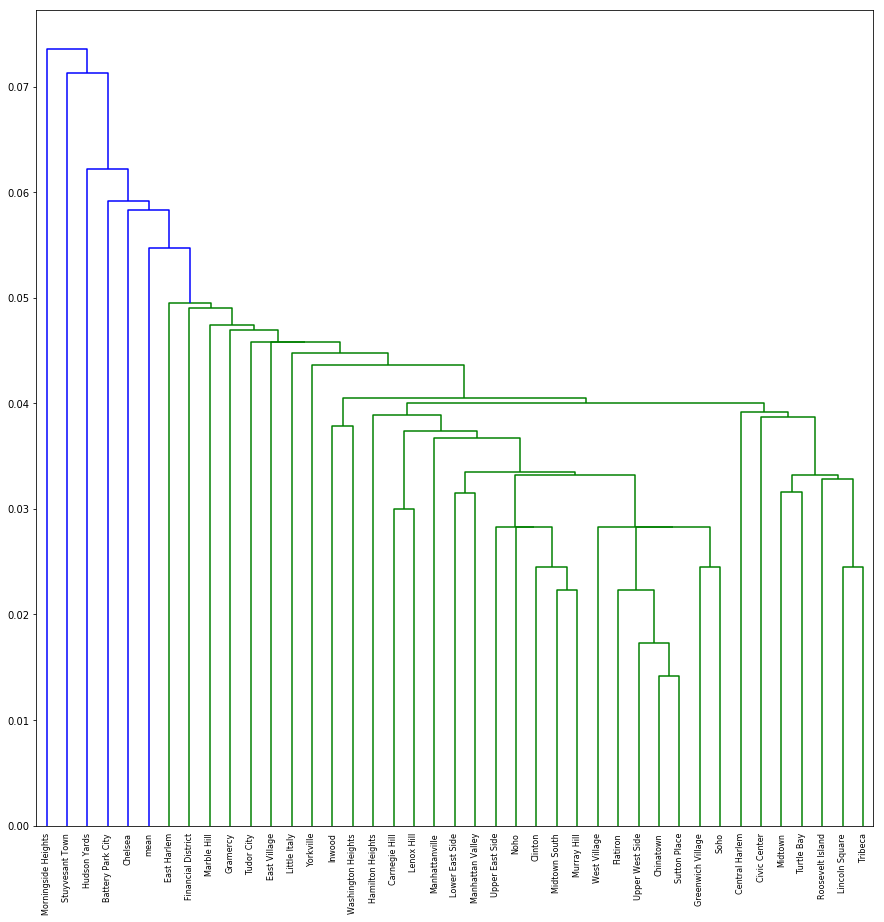

In [222]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist 
from scipy.cluster.hierarchy import linkage, dendrogram

X = manhattan_cutted.drop(columns='Neighborhood').values #Transpose values 
Y = pdist(X)
Z = linkage(X,'single')
plt.figure(figsize=(15, 15))  
dendrogram(Z,leaf_rotation=90,labels=manhattan_cutted['Neighborhood'].values)
plt.show()

In [225]:
# set number of clusters
kclusters = 9

manhattan_grouped_clustering = manhattan_cutted.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=100).fit(manhattan_grouped_clustering)

kmeans.labels_

array([7, 8, 1, 3, 1, 2, 8, 5, 1, 4, 1, 1, 1, 0, 4, 5, 8, 6, 5, 0, 1, 1, 3,
       2, 2, 7, 2, 1, 6, 1, 7, 1, 6, 6, 2, 2, 1, 5, 1, 8, 2], dtype=int32)

## See group of best matched Neighborhoods

In [226]:
manhattan_selected = manhattan_cutted[kmeans.labels_==2]
manhattan_selected

,Neighborhood,Café,Hotel,Restaurant,Coffee Shop,Bakery,Park,Ice Cream Shop,Gym
5,Civic Center,0.020000,0.020000,0.000000,0.030000,0.050000,0.03000,0.000000,0.030000
23,Midtown,0.020000,0.060000,0.000000,0.040000,0.030000,0.03000,0.000000,0.020000
24,Midtown South,0.010000,0.040000,0.020000,0.040000,0.030000,0.00000,0.000000,0.010000
26,Murray Hill,0.010000,0.040000,0.020000,0.040000,0.020000,0.00000,0.000000,0.030000
34,Turtle Bay,0.030000,0.040000,0.000000,0.040000,0.010000,0.03000,0.000000,0.010000
35,Upper East Side,0.010000,0.030000,0.000000,0.040000,0.040000,0.01000,0.000000,0.000000
mean,mean,0.051552,0.046746,0.031426,0.031338,0.030869,0.03066,0.028911,0.028846


## Plot the most suit Neighborhoods on the map

In [197]:
manhattan_merged = manhattan_data[kmeans.labels_[:40]==2]
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="hotel_app")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

The geograpical coordinate of Manhattan are 40.7900869, -73.9598295.
